# EDA

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

日付をインデックスとして使用してデータをロードする

In [2]:
cleandata = pd.read_csv('time-series-prediction\price_clean_full_asc.csv',parse_dates=True,index_col='date')

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_45576\288528175.py:1: SyntaxWarning: invalid escape sequence '\p'
  cleandata = pd.read_csv('time-series-prediction\price_clean_full_asc.csv',parse_dates=True,index_col='date')


In [3]:
cleandata.head()

,close,open,high,low,change,volume
date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,0.1625,1.280000e+09
1987-02-13,172.5,176.5,176.5,172.5,-0.0543,4.223800e+08
1987-02-16,175.5,166.7,175.5,165.7,0.0174,3.605100e+08
1987-02-17,182.4,176.5,184.3,175.5,0.0393,8.815100e+08
1987-02-18,191.2,186.3,191.2,186.3,0.0482,7.950900e+08


## 株価、変化率、取引量を時間に対してプロットする

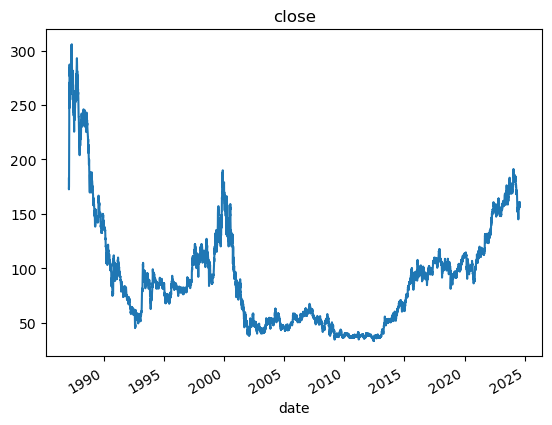

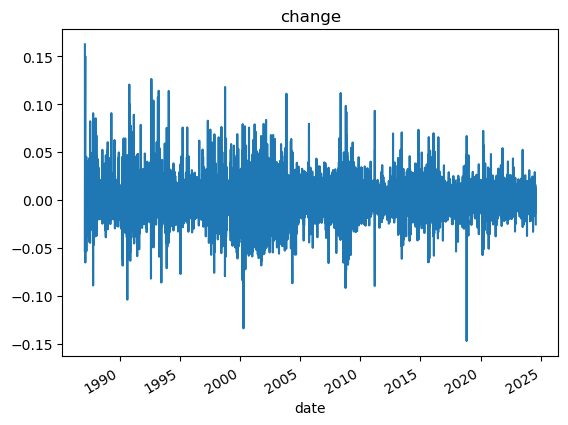

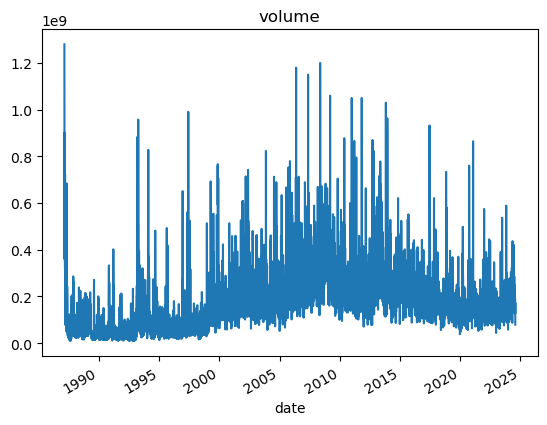

In [4]:
for colname in ['close','change','volume']:
    plt.title(colname)
    cleandata[colname].plot()
    plt.show()

### 株価、変化率、取引量分布の履歴プロット

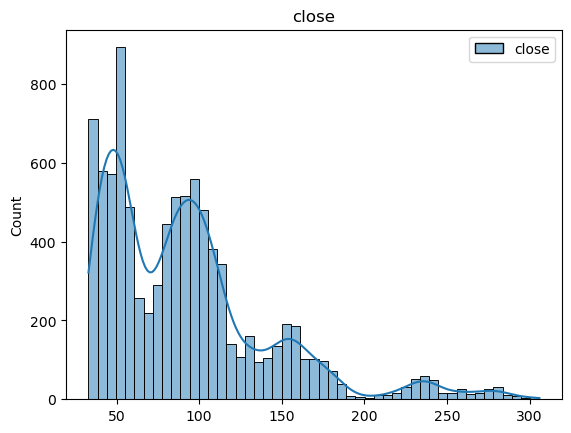

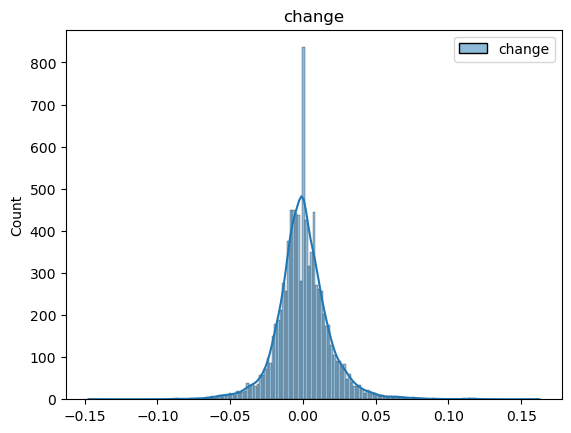

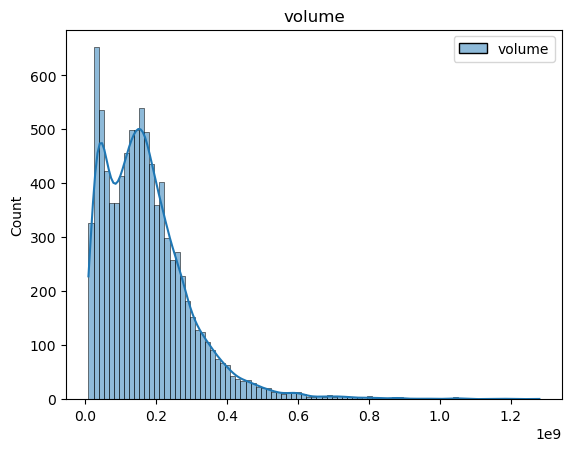

In [5]:
for colname in ['close','change','volume']:
    plt.title(colname)
    sns.histplot(data=cleandata[[colname]], kde=True)
    plt.show()

## 価格、数量、変化の相関関係を確認する

In [11]:
cleandata[['close','change','volume']].corr()

,close,change,volume
close,1.000000,0.017166,-0.317508
change,0.017166,1.000000,0.130238
volume,-0.317508,0.130238,1.000000


統計的に有意な相関関係はない

## 定常過程を確認する

In [10]:
for colname in ['close','change','volume']:
    print(colname,adfuller(cleandata[[colname]])[1])

close 0.006090609914957023
change 0.0
volume 2.095171605290492e-07


 Augmented Dickey- fuller Test は、価格と日々のパーセンテージの変化が定常データであることを示している

## ACF, PACF

### 価格

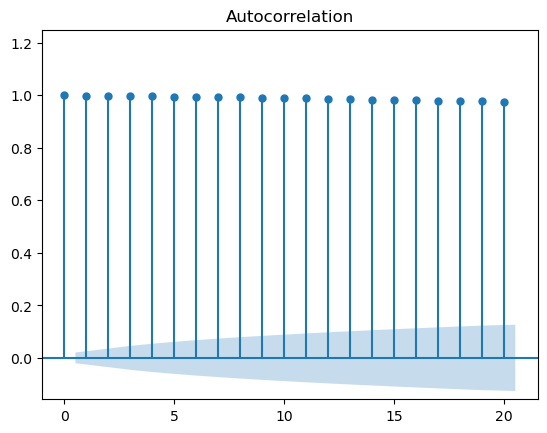

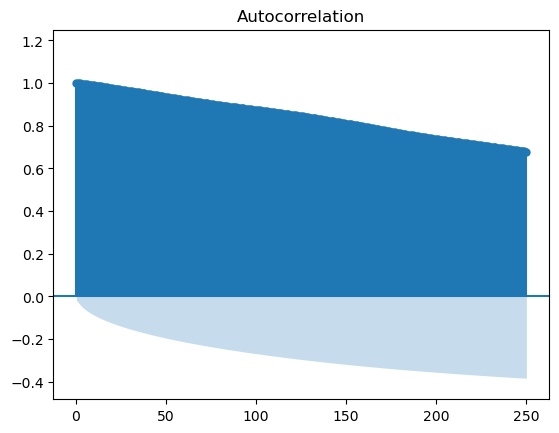

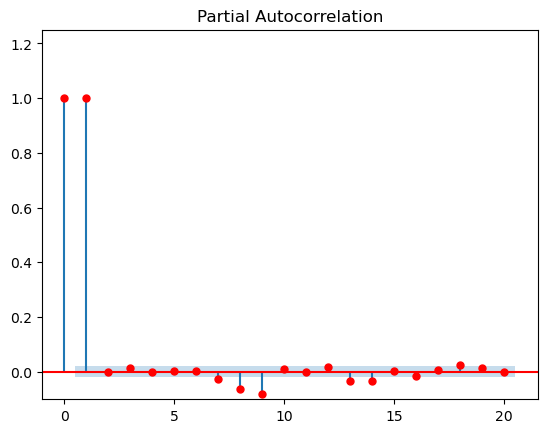

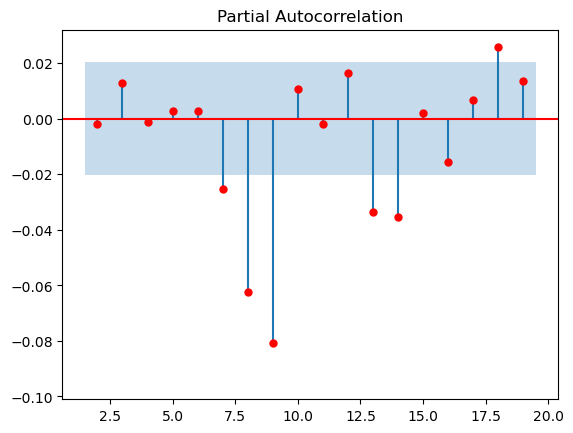

In [15]:
#cleandata[['change']]
plot_acf(cleandata[['close']], auto_ylims=True,lags=20);
plot_acf(cleandata[['close']], auto_ylims=True,lags=250);
plot_pacf(cleandata[['close']], lags=20, method='ywm',c='red',auto_ylims=True);
plot_pacf(cleandata[['close']], lags=list(range(2,20)), method='ywm',c='red',auto_ylims=True);



自己相関関数（ACF）プロットのバーの高さが徐々に減少していることは、データの長期的な依存関係を示しています。
AR モデル
ACF の緩やかな減少と PACF の急激なカットオフは、AR モデルを示唆しています。


### 株価の日次相対変化

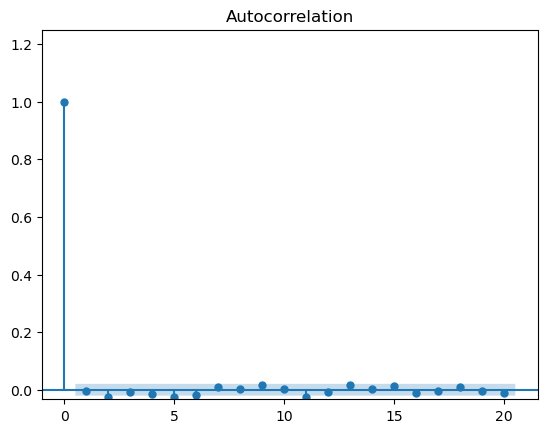

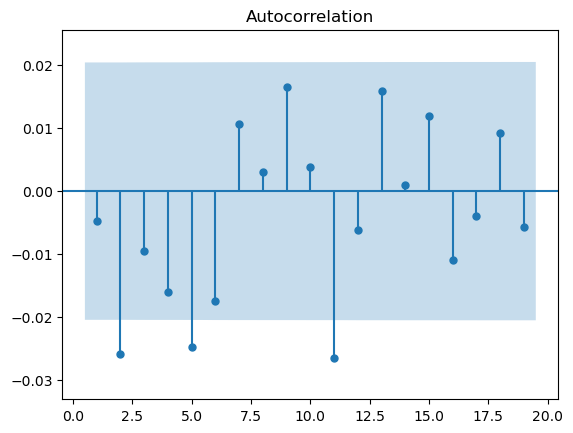

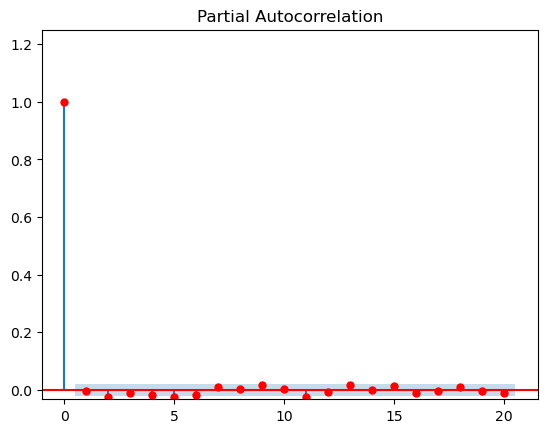

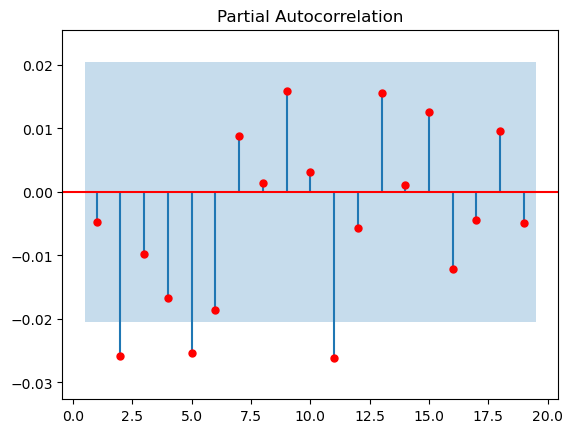

In [20]:
plot_acf(cleandata[['change']], auto_ylims=True,lags=20);
plot_acf(cleandata[['change']], auto_ylims=True,lags=list(range(1,20)));
plot_pacf(cleandata[['change']], lags=20, method='ywm',c='red',auto_ylims=True);
plot_pacf(cleandata[['change']], lags=list(range(1,20)), method='ywm',c='red',auto_ylims=True);

日々の相対価格変化に関する AR、MA はありません。

## **トレンド**、**季節性**、**ノイズ** 間のデータの分解

データの背後に年間の傾向があると仮定する

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
# 1 year = 244 trading days
decomp_add = seasonal_decompose(cleandata['close'], model="additive", period=244)
decomp_mult = seasonal_decompose(cleandata['close'], model="multiplicative", period=244)

加算による分解:
データ = 傾向 + 季節性 + 残差

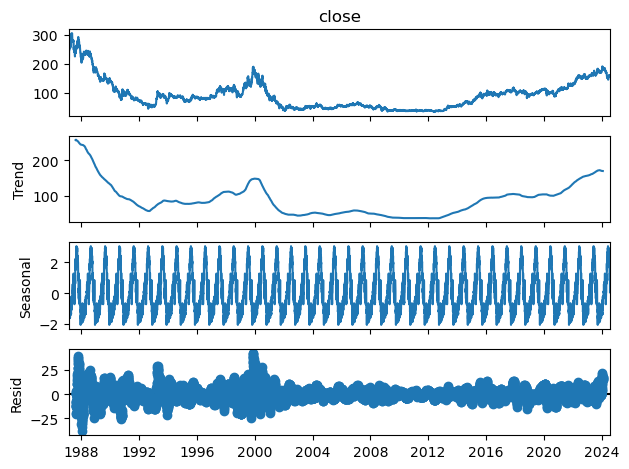

In [28]:
decomp_add.plot();

掛け算で分解:
データ=傾向 *季節 *残差

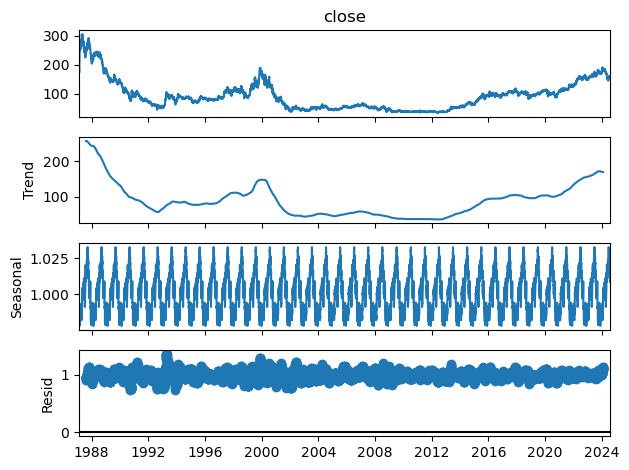

In [29]:
decomp_mult.plot();

加法分解を使用してこの時系列を季節性なしに変換する

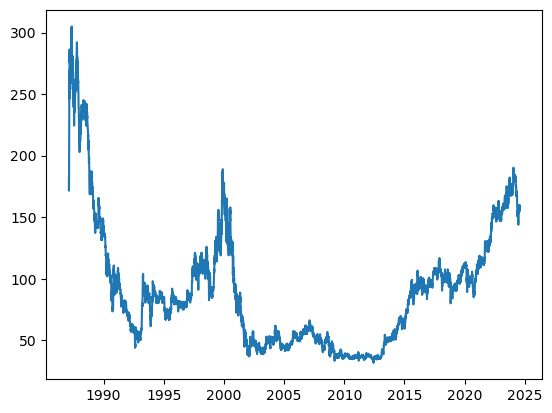

In [30]:
plt.plot(cleandata.close - decomp_add.seasonal);

時系列の残差をプロットする

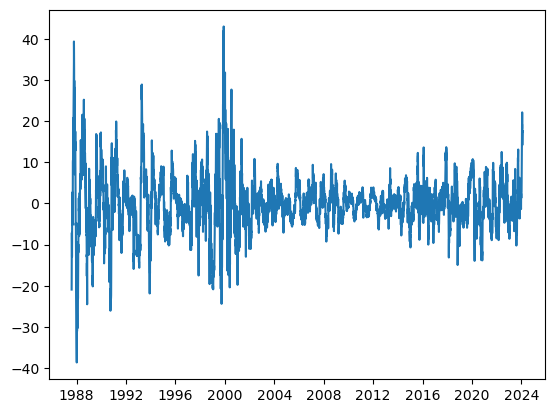

In [32]:
plt.plot(decomp_add.resid);

価格は1日ごとに変動します

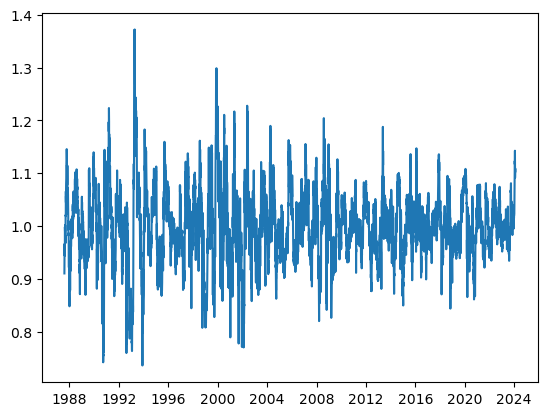

In [31]:
plt.plot(decomp_add.resid);

残差プロットは、株価に SARIMA を使用する場合、より定常な分散を示す 2004 年以降のデータを使用する方がよいことを示しています。
全体として、残差は定常平均を示しています。

さらに、季節的な傾向を加えても、1日あたりの価格変動は10%未満しか説明できないことがわかります。
そして、価格の全体的な傾向は予測できません。